In [16]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = 1

In [3]:
#adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [4]:
#adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [9]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [10]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [11]:
adata_ood = adata_ood[adata_ood.obs["condition"]!="control"]

In [12]:
#adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [13]:
adata_full = ad.concat((adata_train, adata_ood))

In [20]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [21]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [22]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [23]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 466, in _make_request
    self._validate_conn(conn)
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 1095, in _validate_conn
    conn.connect()
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 652, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 805, in _ssl_wrap_socket_and_match_hostname
    ssl_sock = ssl_wrap_socket(
               ^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/util/ssl_.py", line 465, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(sock, context, tls_in_tls, server_hostnam

In [26]:
sc.tl.rank_genes_groups(adata_full, "condition", method="t-test", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_g

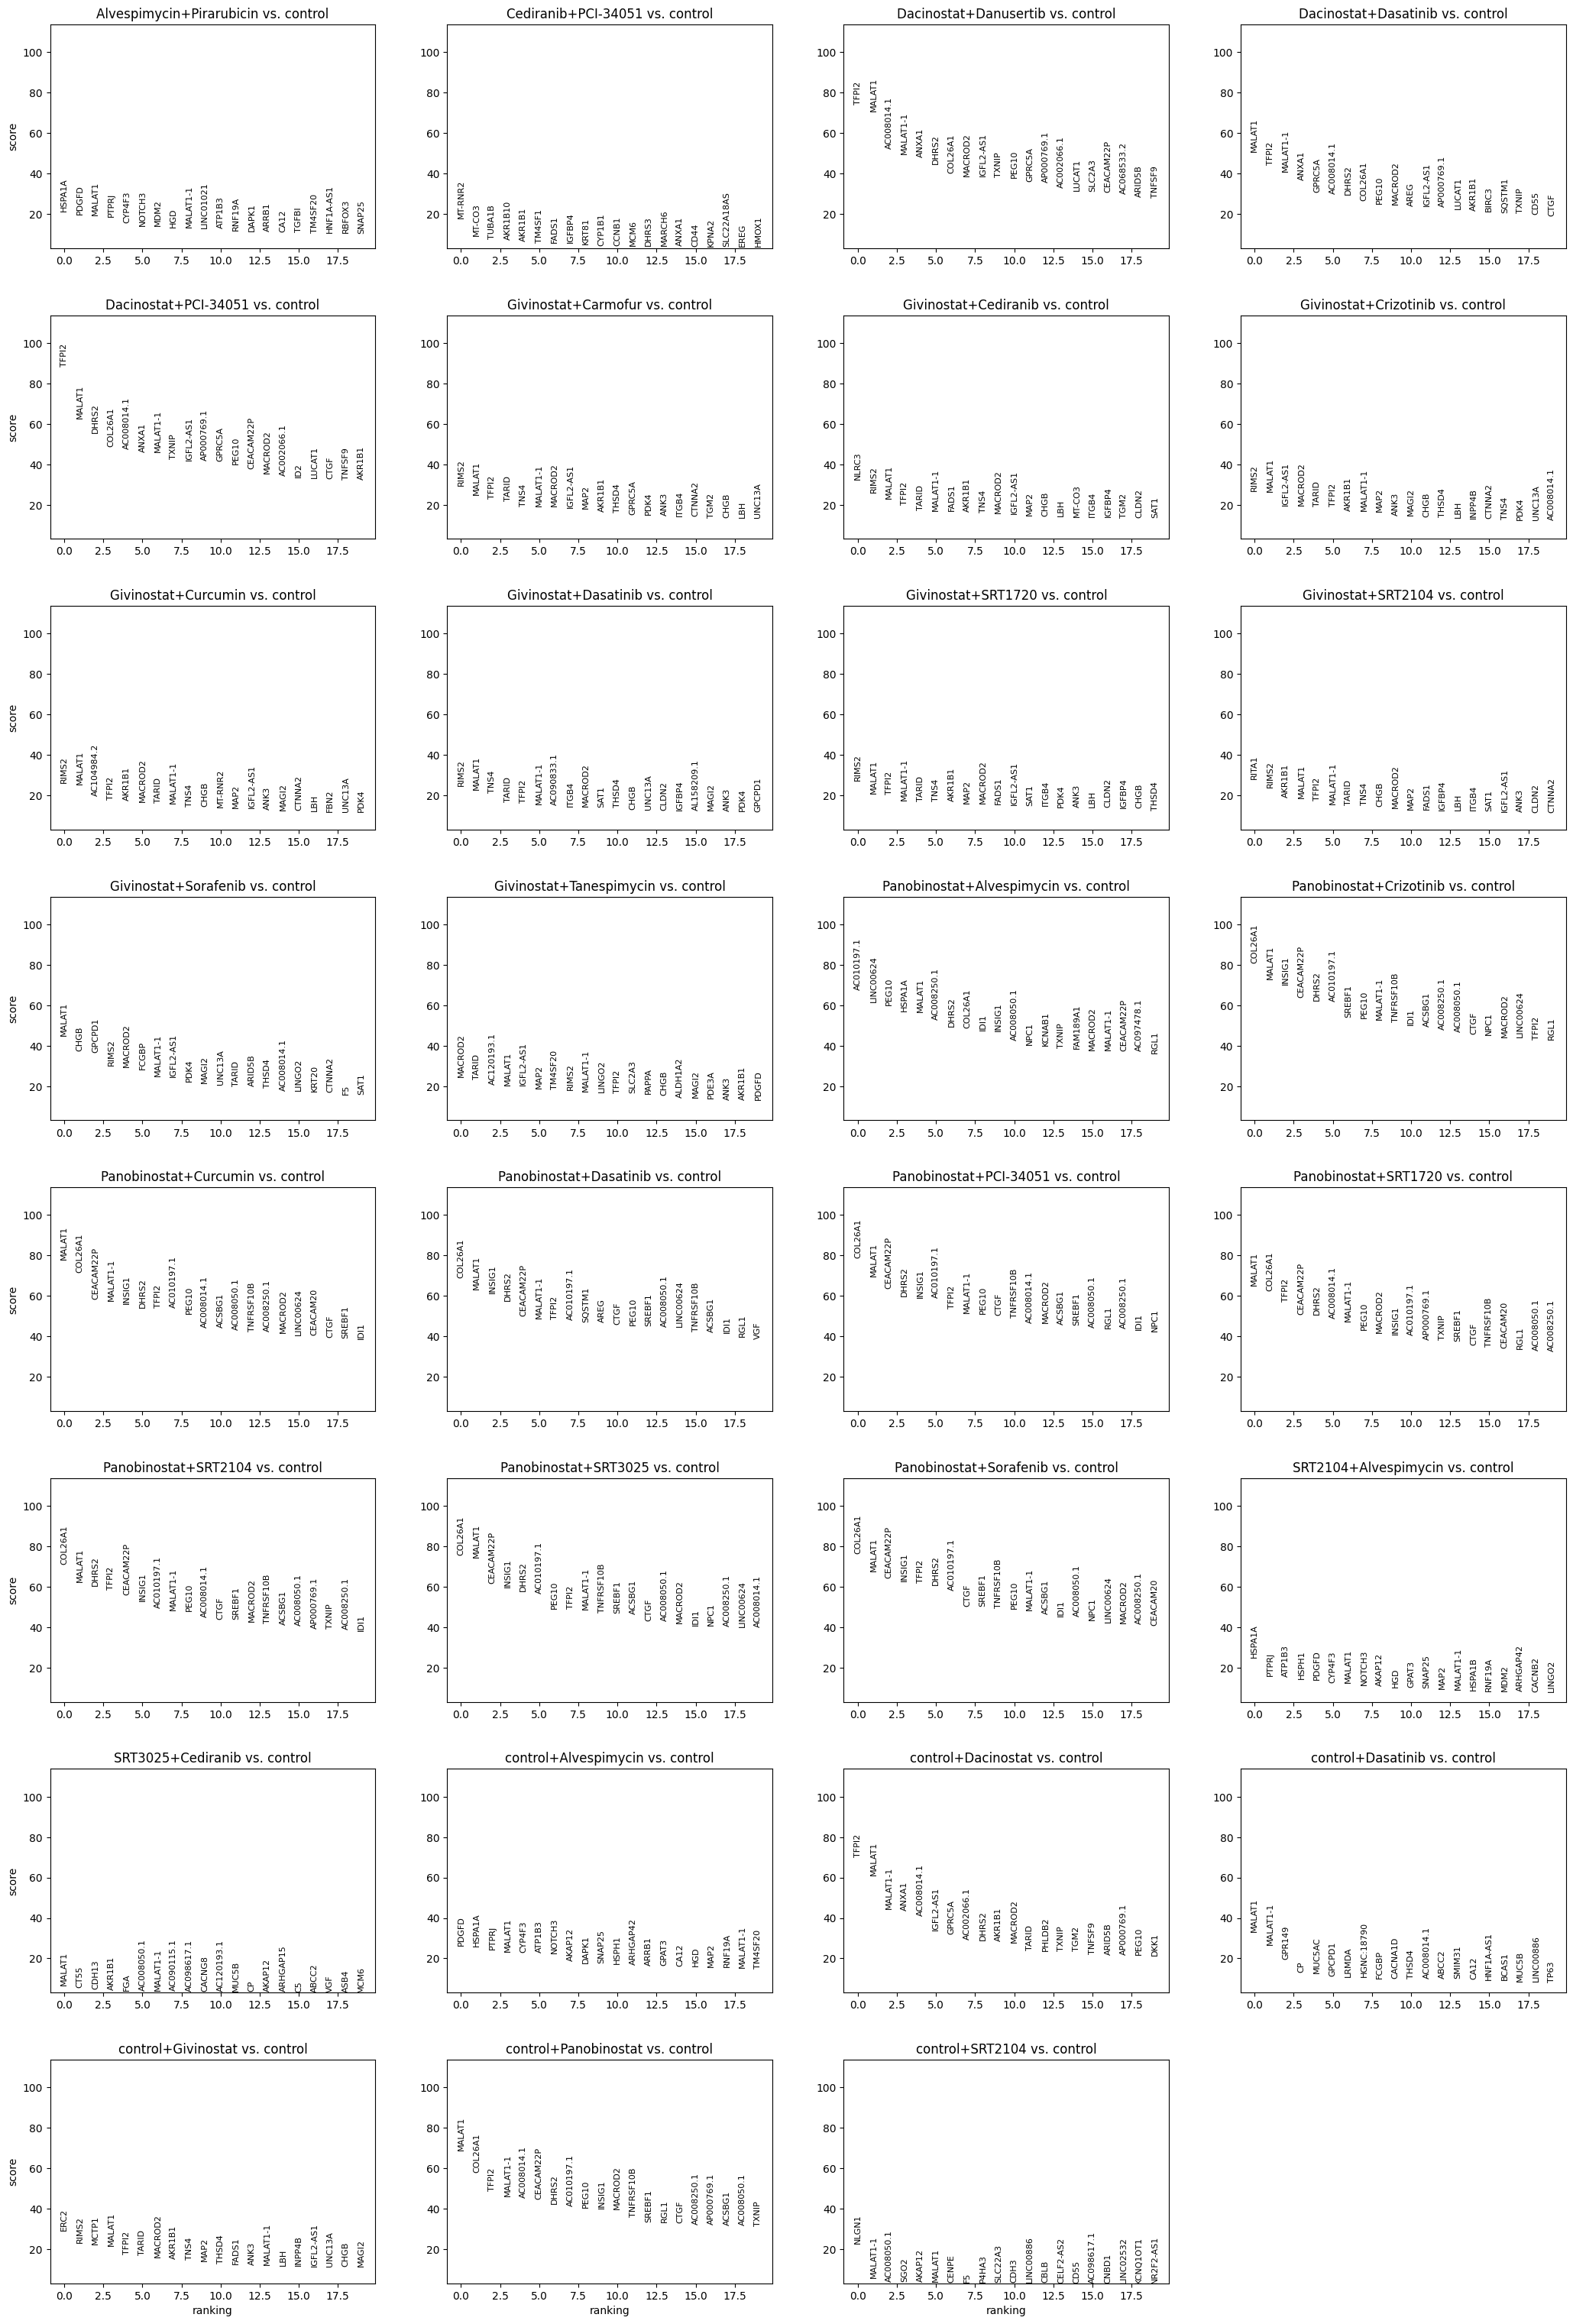

In [57]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [32]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_2479694/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [33]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [34]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+SRT1720', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin'])

In [35]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_G2_M_CHECKPOINTS,-0.920983,-2.087043,0.000000
REACTOME_DNA_REPAIR,-0.927977,-2.167845,0.000000
REACTOME_HOMOLOGY_DIRECTED_REPAIR,-0.941138,-1.847103,0.000000
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,-0.909695,-2.076989,0.000000
REACTOME_CHROMOSOME_MAINTENANCE,-0.896233,-1.727588,0.000000
...,...,...,...
REACTOME_SIGNALING_BY_NTRKS,0.304445,0.672656,0.897756
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION,0.289509,0.540430,0.949451
REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES,-0.282508,-0.506095,0.965580


In [ ]:
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # 'Alvespimycin+Pirarubicin'
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # maybe even more interesting, as it's for 'Givinostat+Tanespimycin' and 'Alvespimycin+Pirarubicin'
'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53' # affects many conditions, a bit random

In [39]:
res = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY']["pval"]

In [40]:
res


{'Alvespimycin+Pirarubicin': 0.07155026,
 'Cediranib+PCI-34051': 0.50200266,
 'Dacinostat+Danusertib': 0.0,
 'Dacinostat+Dasatinib': 0.0,
 'Dacinostat+PCI-34051': 0.0,
 'Givinostat+Carmofur': 0.0,
 'Givinostat+Cediranib': 0.009404388,
 'Givinostat+Crizotinib': 0.01831502,
 'Givinostat+Curcumin': 0.034883723,
 'Givinostat+SRT2104': 0.015503876,
 'Givinostat+Sorafenib': 0.0,
 'Givinostat+Tanespimycin': 0.0030487804,
 'Panobinostat+Alvespimycin': 0.0045351475,
 'Panobinostat+Crizotinib': 0.005602241,
 'Panobinostat+Curcumin': 0.0024875621,
 'Panobinostat+SRT1720': 0.0025316456,
 'Panobinostat+SRT3025': 0.0,
 'Panobinostat+Sorafenib': 0.002793296,
 'SRT2104+Alvespimycin': 0.23020528}

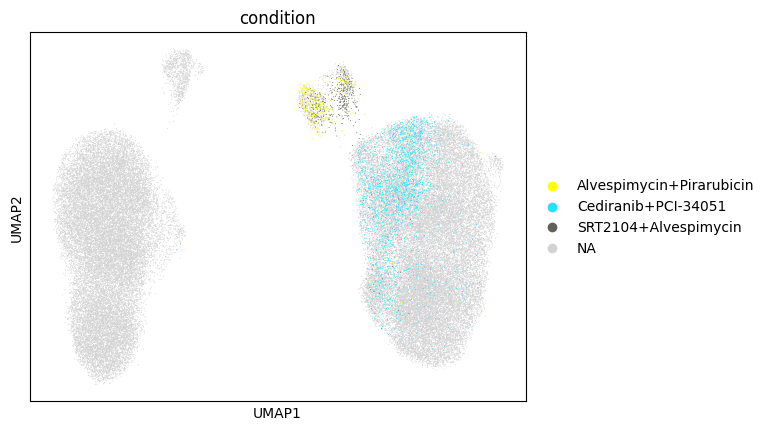

In [43]:
sc.pl.umap(adata_full, color="condition", groups=['Cediranib+PCI-34051', 'SRT2104+Alvespimycin', 'Alvespimycin+Pirarubicin'])

In [48]:
adata_ood.obs["condition"].value_counts()

condition
SRT3025+Cediranib         3016
Givinostat+Dasatinib      2421
control+Dasatinib         2343
Givinostat+SRT1720        2260
Panobinostat+SRT2104      1971
Panobinostat+Dasatinib    1955
Panobinostat+PCI-34051    1814
Name: count, dtype: int64

In [55]:
split = 3
ood_tmp_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"
adata_ood_tmp = sc.read_h5ad(ood_tmp_path)

In [56]:
adata_ood_tmp.obs["condition"].value_counts()

condition
Panobinostat+Curcumin      2244
Panobinostat+Sorafenib     2013
control+Dacinostat         1869
Panobinostat+SRT1720       1826
Panobinostat+Crizotinib    1641
control+Alvespimycin        758
SRT2104+Alvespimycin        520
control                     500
Name: count, dtype: int64

In [44]:
res = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53']["pval"]

In [45]:
res


{'Alvespimycin+Pirarubicin': 0.0099502485,
 'Cediranib+PCI-34051': 0.013767209,
 'Dacinostat+Danusertib': 0.009049774,
 'Dacinostat+Dasatinib': 0.009124087,
 'Dacinostat+PCI-34051': 0.010958904,
 'Givinostat+Carmofur': 0.004716981,
 'Givinostat+Cediranib': 0.032786883,
 'Givinostat+Crizotinib': 0.0,
 'Givinostat+Curcumin': 0.0,
 'Givinostat+SRT2104': 0.030612245,
 'Givinostat+Sorafenib': 0.0025575447,
 'Givinostat+Tanespimycin': 0.013245033,
 'Panobinostat+Alvespimycin': 0.04694836,
 'Panobinostat+Crizotinib': 0.075987846,
 'Panobinostat+Curcumin': 0.015189873,
 'Panobinostat+SRT1720': 0.022038568,
 'Panobinostat+SRT3025': 0.05929919,
 'Panobinostat+Sorafenib': 0.03583062,
 'SRT2104+Alvespimycin': 0.17307693}

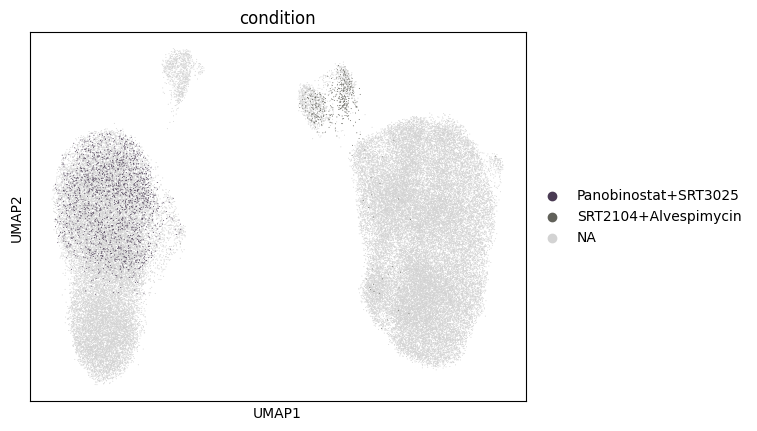

In [47]:
sc.pl.umap(adata_full, color="condition", groups=['SRT2104+Alvespimycin', 'Panobinostat+SRT3025'])

In [157]:
[el for el in adata_train.var_names if "TP" in el] 

['ATP1B3',
 'TP63',
 'TPX2',
 'ATP1B2',
 'PTPRJ',
 'PTPRD',
 'PITPNC1',
 'TPPP3',
 'CTPS1',
 'MCTP1',
 'TPRX1',
 'ATP13A5',
 'GRTP1-AS1',
 'ATP6V1G2-DDX39B']

In [151]:
adata_ood.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
Givinostat+Cediranib         2783
Givinostat+Curcumin          2736
Panobinostat+SRT3025         1889
control+Panobinostat         1578
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
Name: count, dtype: int64

In [101]:
import seaborn.objects as so

In [111]:
[el for el in gsea_results.index.values if "EGFR" in el]

[]

In [102]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/seaborn/_core/plot.py:1043: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.savefig(buffer, dpi=dpi, format="png", bbox_inches="tight")


KeyboardInterrupt: 